<a href="https://colab.research.google.com/github/timsetsfire/wandb-examples/blob/main/colab/Training_20230504.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training 20230504

## Logging
* Computer vision tools (e.g. can we dump images with the largest error?)
* Model understanding (e.g. a heatmap showing what part of the detection led to the label)

## API 
* Exporting results to BigQuery for our production workflows

## Artifacts
* The artifact store and general story around saving models


In [13]:
%%capture
!pip install -q -U mdai wandb

In [3]:
import wandb
import os 
os.environ["WANDB_PROJECT"] = "training-20230504"
# p.show_label_groups()

# Logging Images

```
Image(
 data_or_path: "ImageDataOrPathType",
 mode: Optional[str] = None,
 caption: Optional[str] = None,
 classes: Optional[Union['Classes', Sequence[dict]]] = None,
 boxes: Optional[Union[Dict[str, 'BoundingBoxes2D'], Dict[str, dict]]] = None,
 masks: Optional[Union[Dict[str, 'ImageMask'], Dict[str, dict]]] = None
) -> None
```

In [15]:
with wandb.init() as run:
  image = np.random.randint(low=0, high=256, size=(100, 100, 3), dtype=np.uint8)
  predicted_mask = np.empty((100, 100), dtype=np.uint8)
  ground_truth_mask = np.empty((100, 100), dtype=np.uint8)
  predicted_mask[:50, :50] = 0; predicted_mask[50:, :50] = 1; predicted_mask[:50, 50:] = 2; predicted_mask[50:, 50:] = 3
  ground_truth_mask[:25, :25] = 0; ground_truth_mask[25:, :25] = 1; ground_truth_mask[:25, 25:] = 2; ground_truth_mask[25:, 25:] = 3

  class_labels = {
      0: "person",
      1: "tree",
      2: "car",
      3: "road"
  }

  masked_image = wandb.Image(image, masks={
      "predictions": {
          "mask_data": predicted_mask,
          "class_labels": class_labels
      },
      "ground_truth": {
          "mask_data": ground_truth_mask,
          "class_labels": class_labels
      }
  })
  wandb.log({"img_with_masks" : masked_image})

# Logging Sequences of Images

In [5]:
from PIL import Image, ImageFilter
with wandb.init() as run:
  !curl https://parade.com/.image/t_share/MTkwNTgwOTUyNjU2Mzg5MjQ1/albert-einstein-quotes-jpg.jpg > image.jpg
  im = Image.open("./image.jpg").resize((512, 512)) 
  for i in range(15):
    run.log({"blurring einstein": wandb.Image(im)})
    im = im.filter(ImageFilter.GaussianBlur(radius=1.5))  

# Logging Arrays of images

Successfully authenticated to public.md.ai.
Using path './lesson1-data' for data.
Preparing annotations export for project PVq9raBJ...                                                
Using cached annotations data for project PVq9raBJ.
Preparing images export for project PVq9raBJ...                                                     
Using cached images data for project PVq9raBJ.
{'L_38Y7Jl': 0, 'L_z8xEkB': 1}
10


In [7]:
with wandb.init() as run:
  images = [mdai.visualize.load_dicom_image(image_id, to_RGB=True) for image_id in  val_dataset.image_ids]
  wandb_images = [wandb.Image(image) for image in images]
  wandb.log({"images": wandb_images})

## Logging Tables of Images

In [8]:
import pandas as pd 
with wandb.init() as run:
  df = pd.DataFrame(wandb_images, columns = ["images"])
  run.log({"image-table": df})



## Model Understanding Use Case

Using GradCam to visualize activation maps



Successfully authenticated to public.md.ai.
Using path './lesson1-data' for data.
Preparing annotations export for project PVq9raBJ...                                                
Using cached annotations data for project PVq9raBJ.
Preparing images export for project PVq9raBJ...                                                     
Using cached images data for project PVq9raBJ.
{'L_38Y7Jl': 0, 'L_z8xEkB': 1}
10


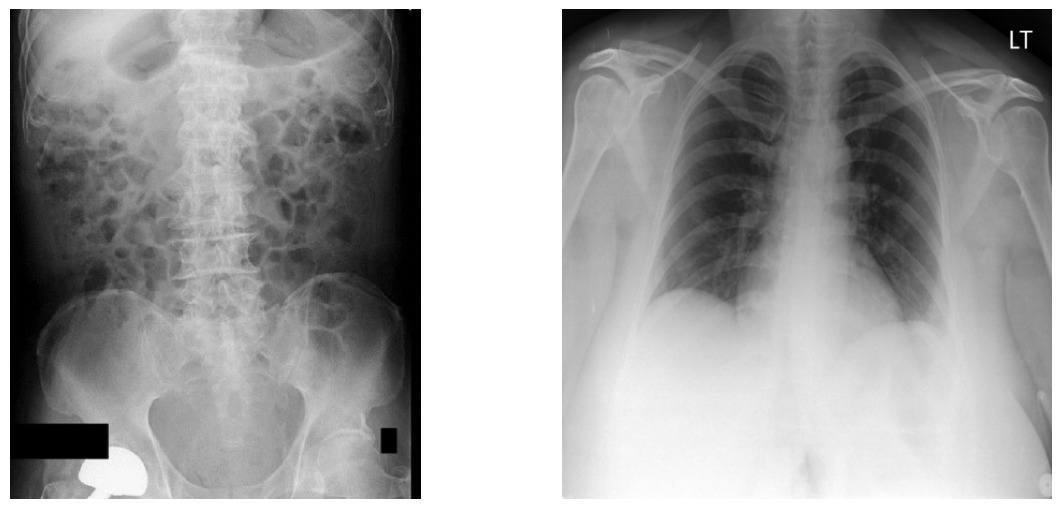

In [17]:
## get data
import mdai
import wandb 
mdai_client = mdai.Client(domain='public.md.ai', access_token="9f783fcb3f049edb419994ddf870a39d")
p = mdai_client.project('PVq9raBJ', path='./lesson1-data')
# # this maps label ids to class ids as a dict obj
labels_dict = {
    'L_38Y7Jl': 0, # Abdomen 
    'L_z8xEkB': 1, # Chest  
}
print(labels_dict)
p.set_labels_dict(labels_dict)
val_dataset = p.get_dataset_by_name('VAL')
val_dataset.prepare()
val_image_ids = val_dataset.get_image_ids()
print(len(val_image_ids))
mdai.visualize.display_images(val_image_ids[:2], cols=2)

In [18]:
import numpy as np
import tensorflow as tf
from PIL import Image
from tf_explain.core.grad_cam import GradCAM
import cv2
import matplotlib.pyplot as plt
import pandas as pd
img_width = 224
img_height = 224

plt.figure(figsize=(20, 10))
import pandas 
data = []
with wandb.init() as run:

  artifact = run.use_artifact('tim-w/medical/model_gen:v0', type='model')
  artifact_dir = artifact.download()

  model = tf.keras.models.load_model(f'{artifact_dir}/model.h5')

  for i, image_id in enumerate(val_dataset.image_ids): 
      
      image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
      image = Image.fromarray(image)
      image = image.resize((img_width, img_height))
      
      X = np.empty((1, img_width, img_height, 3))
      X[0,:] = image
      y_prob = model.predict(X)
      y_classes = y_prob.argmax(axis=-1)
      
      pred_class = val_dataset.class_id_to_class_text(y_classes[0])
      pred_prob = y_prob[0][y_classes[0]]

      
      explainer1 = GradCAM()
      output1 = explainer1.explain(
          validation_data=(X, None),
          model=model,
          layer_name="conv_pw_13",
          class_index=y_classes[0],
          colormap=cv2.COLORMAP_TURBO,
      )
      
      wandb_image = wandb.Image(image, caption = f"pred class {pred_class}, pred prob {pred_prob:.2f}")
      wandb_image1 = wandb.Image(output1, caption = f"pred class {pred_class}, pred prob {pred_prob:.2f}")
      
      # data.append([wandb_image, wandb_image1, wandb_image2])
      wandb.log({"image examples": [wandb_image, wandb_image1]}, step = i)
      e = {"image": wandb_image, "GradCam Viz": wandb_image1, "pred_class": pred_class,  "pred_prob": pred_prob}
      data.append(e)
  df = pd.DataFrame( data)
  wandb.log({"table": wandb.Table(dataframe=df)})    

wandb:   1 of 1 files downloaded.  


1/1 [==============================] - 0s 198ms/step


<Figure size 2000x1000 with 0 Axes>

# API

In [31]:
api = wandb.Api()
runs = api.runs("tim-w/wandb-training")

In [34]:
for run in runs:
  if run.job_type == "training":
    break

In [35]:
run.history()

,global_step,Train Metrics/loss,Validation Metrics/loss,Validation Metrics/accuracy,_step,epoch,_runtime,_timestamp
0,24,0.380622,NaN,NaN,0,0.380622,5.803636,1.660228e+09
1,49,0.136904,NaN,NaN,1,0.136904,8.533109,1.660228e+09
2,74,0.102546,NaN,NaN,2,0.102546,10.618428,1.660228e+09
3,79,NaN,0.193344,0.9635,3,0.000000,11.630424,1.660228e+09
4,99,0.081171,NaN,NaN,4,0.081171,13.417439,1.660228e+09
5,124,0.089441,NaN,NaN,5,0.089441,15.538342,1.660228e+09
6,149,0.100029,NaN,NaN,6,0.100029,17.685438,1.660228e+09
7,158,NaN,0.122383,0.9585,7,1.000000,19.010154,1.660228e+09
8,174,0.041224,NaN,NaN,8,0.041224,20.424110,1.660228e+09
9,199,0.037769,NaN,NaN,9,0.037769,22.389858,1.660228e+09


In [37]:
run.summary

{'epoch': 3, 'Validation Metrics/loss': 0.07407831400632858, 'Validation Metrics/accuracy': 0.9735000133514404, '_step': 15, '_runtime': 33.494813680648804, '_timestamp': 1660227893.6349056, 'global_step': 316, 'Train Metrics/loss': 0.04200053587555885, '_wandb': {'runtime': 40}}